In [22]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import random
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools import mask
from PassionateMix_v2 import *
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors
# 저장 경로
save_dir = '/opt/ml/segmentation/input/data/augmented/'
file_name_dir = 'augmented/'

# 데이터셋 경로
dataset_path  = '/opt/ml/segmentation/input/data/'
# 증강 파일
json_path = dataset_path + 'mix_9+341_10+264_3+335_4+260_5+161.json'
coco = COCO(json_path)

loading annotations into memory...
Done (t=3.43s)
creating index...
index created!


In [23]:
# 증강시킬 json 파일 읽기
with open(json_path, 'r') as f:
    json_data = json.load(f)


# 카테고리 이름 설정
df = pd.read_csv('/opt/ml/segmentation/baseline_code/class_dict.csv')
category_names = list(df.name)

# 증강시킬 mask_class 번호 지정
mask_class = 3

In [24]:
# 원하는 mask_class가 들어있는 images의 인덱스들 추출
foreground_images = []

for idx in tqdm(range(len(json_data['images']))):
    image_id = coco.getImgIds(imgIds=idx)
    image_infos = coco.loadImgs(image_id)[0]
    
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    
    category_type = []
    for i in range(len(anns)):
        category_id = anns[i]['category_id']
        if category_id == mask_class:
            foreground_images.append(idx)
            break

100%|██████████| 2625/2625 [00:00<00:00, 10173.90it/s]


In [25]:
# json data 파일의 마지막 images id 추출
last_images_id = json_data['images'][-1]['id']

# mask_class가 없는 이미지에 증강시킬 목적으로 
# mask_class가 없는 이미지들의 인덱스 background_images 선언
background_images = range(last_images_id)
background_images = [x for x in background_images if x not in foreground_images]
len(foreground_images)

670

/opt/conda/envs/segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:38: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_values except for the argument 'by' will be keyword-only


Number of super categories: 10
Number of categories: 10
Number of annotations: 22613
Number of images: 2625


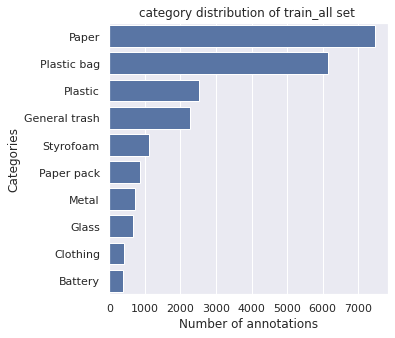

In [26]:
categories = json_data['categories']
anns = json_data['annotations']
imgs = json_data['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total", color="b")
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [6]:
cnt = 0
dic_cls = dict([(idx+1,0) for idx, val in enumerate(range(10))])
for idx in tqdm(range(len(json_data['images']))):
    image_id = coco.getImgIds(imgIds=idx)
    image_infos = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(anns)):
        dic_cls[anns[i]['category_id']] += 1
        cnt += 1
print(dic_cls)
print(cnt)

100%|██████████| 2625/2625 [00:00<00:00, 32149.13it/s]

{1: 2280, 2: 7481, 3: 535, 4: 458, 5: 512, 6: 2534, 7: 1127, 8: 6147, 9: 385, 10: 398}
21857


In [10]:
len(foreground_images)

335

In [11]:
# 증강시킬 개수 k
random.seed(16)
k = 335

fg_image_idx = random.sample(foreground_images, k)
bg_image_idx = random.sample(background_images, k)
print(k, len(fg_image_idx), len(bg_image_idx))

335 335 335


In [12]:
for fg_idx, bg_idx in tqdm(zip(fg_image_idx, bg_image_idx)):
    # background 처리
    bg_masks, bg_images, bg_image_infos = get_image_detail(dataset_path, bg_idx, coco, category_names)
    print('bg_image_infos:',bg_image_infos)
    edge, empty_ymax, empty_xmax = find_background_space(bg_masks)
    
    # 만약 배경이 없는 사진이라면 해당 iter는 continue
    if (bg_masks == 0).sum() == 0:
        continue
    
    # foreground 처리
    fg_masks, fg_images, fg_image_infos = get_image_detail(dataset_path, fg_idx, coco, category_names)
    fg, fg_bbox = find_foreground_bbox(fg_masks, fg_images, mask_class)
    
    # resize
    resized_fg, segmentation_mask = resize_foreground_backgroud(fg_masks, fg, fg_bbox, empty_ymax, empty_xmax, edge)
    
    # background, foreground merge & save
    merged_image = merge_bg_fg(bg_images, resized_fg, empty_ymax, empty_xmax, edge)
    save_merged_image(save_dir, file_name_dir, merged_image, bg_image_infos, fg_image_infos, mask_class)
    
    # json file 처리
    json_data, annotation = make_coco_annotation(file_name_dir, bg_image_infos, fg_image_infos, mask_class, segmentation_mask, json_data)
    json_data['annotations'].append(annotation)

0it [00:00, ?it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1077.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 674}


1it [00:00,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1686_augmented_9_1660_batch_01_vt_0002.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}


2it [00:01,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0054.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 786}


3it [00:02,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0249.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 906}


4it [00:02,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1373}


5it [00:03,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1885.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1939}


6it [00:03,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0203.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 125}


7it [00:04,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0396.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 246}


8it [00:05,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0863.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 546}


9it [00:06,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0680.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2443}


10it [00:06,  1.39it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0842.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2528}


11it [00:07,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1583_augmented_9_1357_batch_01_vt_0007.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 4}


12it [00:08,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0930.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 588}


13it [00:08,  1.70it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1144.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1460}


14it [00:09,  1.70it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0591.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 379}


15it [00:09,  1.67it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0820.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2515}


16it [00:10,  1.66it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1605_batch_02_vt_1052.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1410}


17it [00:11,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2118_batch_03_0153.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2105}


18it [00:11,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1106.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 688}


19it [00:12,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_399_batch_03_0004.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2023}


20it [00:13,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0910.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1316}


21it [00:13,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1860.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1923}


22it [00:14,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0822.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2516}


23it [00:15,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0610.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 389}


24it [00:15,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1119.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 695}


25it [00:16,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0328.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 203}


26it [00:16,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1027.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1389}


27it [00:17,  1.65it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0743.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1217}


28it [00:17,  1.70it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1055.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1412}


29it [00:18,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2609_batch_03_0138.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2093}


30it [00:19,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1161.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1469}


31it [00:20,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_875_batch_01_vt_0557.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 354}


32it [00:20,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0732.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1208}


33it [00:21,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1621.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1780}


34it [00:22,  1.38it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1085.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1431}


35it [00:22,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2251_batch_03_0391.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2257}


36it [00:23,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0172.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 107}


37it [00:24,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0919.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 582}


38it [00:24,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0841.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 535}


39it [00:25,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1312.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1566}


40it [00:26,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_2526_batch_02_vt_1803.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1890}


41it [00:26,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0844.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1273}


42it [00:27,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0179.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2121}


43it [00:27,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0962.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1349}


44it [00:28,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0442.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1014}


45it [00:29,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0835.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1269}


46it [00:29,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0118.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 69}


47it [00:30,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0369.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2243}


48it [00:31,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0027.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 18}


49it [00:31,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0268.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 918}


50it [00:32,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_740_batch_02_vt_1931.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1970}


51it [00:33,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1193.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 731}


52it [00:33,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0477.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1037}


53it [00:34,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1321.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1572}


54it [00:35,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1862.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1924}


55it [00:35,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0792.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 504}


56it [00:36,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_94_batch_02_vt_0783.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1242}


57it [00:36,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0088.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 53}


58it [00:37,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1171.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1475}


59it [00:38,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0070.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 797}


60it [00:38,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_184_augmented_9_128_batch_02_vt_1591.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1759}


61it [00:39,  1.67it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1927.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1967}


62it [00:39,  1.68it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0967.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1353}


63it [00:40,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1527.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1716}


64it [00:41,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0407.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 996}


65it [00:41,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2566_augmented_9_2588_batch_01_vt_1214.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 740}


66it [00:42,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0302.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 939}


67it [00:43,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0730.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2468}


68it [00:43,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0304.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 187}


69it [00:44,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0810.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2508}


70it [00:44,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0618.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 395}


71it [00:45,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0880.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1297}


72it [00:46,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1}


73it [00:46,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2498_augmented_9_1378_batch_01_vt_0153.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 97}


74it [00:47,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0950.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2589}


75it [00:48,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2525_batch_01_vt_0718.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 463}


76it [00:48,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0802.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1252}


77it [00:49,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0252.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 907}


78it [00:50,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0783.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 499}


79it [00:50,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_459_augmented_9_447_batch_01_vt_0883.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 558}


80it [00:51,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1196_batch_03_0529.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2352}


81it [00:52,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0504.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2334}


82it [00:53,  1.39it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1475.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1681}


83it [00:53,  1.33it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0176.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 109}


84it [00:54,  1.38it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0024.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 16}


85it [00:55,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0499.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 313}


86it [00:55,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1496_batch_02_vt_0682.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1177}


87it [00:56,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1934.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1973}


88it [00:57,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0873.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 551}


89it [00:57,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1262.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1531}


90it [00:58,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0431.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2285}


91it [00:58,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_495_batch_02_vt_1604.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1768}


92it [00:59,  1.66it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0569.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1101}


93it [01:00,  1.66it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1029_batch_02_vt_0296.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 934}


94it [01:00,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1068.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1420}


95it [01:01,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1246.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 750}


96it [01:01,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1048_batch_02_vt_0472.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1033}


97it [01:02,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2059_augmented_9_1972_batch_02_vt_0163.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 852}


98it [01:03,  1.65it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0097.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 812}


99it [01:03,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1681.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1823}


100it [01:04,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_908_batch_02_vt_1447.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1660}


101it [01:05,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0548.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 347}


102it [01:06,  1.38it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_496_batch_01_vt_0212.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 131}


103it [01:06,  1.35it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0314.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 945}


104it [01:07,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2213_augmented_9_2223_batch_01_vt_1086.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 678}


105it [01:08,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1785_augmented_9_784_batch_02_vt_1889.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1942}


106it [01:08,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1985_batch_01_vt_0668.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 429}


107it [01:09,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0755.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1223}


108it [01:10,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0960.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1347}


109it [01:10,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/2000.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2017}


110it [01:11,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1326.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1575}


111it [01:11,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1236.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1515}


112it [01:12,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_160_batch_02_vt_1746.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1863}


113it [01:13,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_2492_batch_02_vt_0256.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 910}


114it [01:13,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1315.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1568}


115it [01:14,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0661.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1161}


116it [01:15,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0257.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2172}


117it [01:15,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0191.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 118}


118it [01:16,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0851.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2533}


119it [01:16,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1628_batch_01_vt_0150.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 94}


120it [01:17,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1424.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1644}


121it [01:18,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0168.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 106}


122it [01:18,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1068_batch_03_0080.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2067}


123it [01:19,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0860.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2537}


124it [01:20,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1848.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1916}


125it [01:20,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0611.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2405}


126it [01:21,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1871.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1929}


127it [01:22,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0658.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 421}


128it [01:22,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0773.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2489}


129it [01:23,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1067.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 667}


130it [01:24,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0586.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1111}


131it [01:24,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0794.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2503}


132it [01:25,  1.37it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_107_batch_02_vt_0622.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1140}


133it [01:26,  1.38it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0094.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 811}


134it [01:26,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0339.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 209}


135it [01:27,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0073.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 798}


136it [01:28,  1.39it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1918_batch_02_vt_0749.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1219}


137it [01:29,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0449.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1017}


138it [01:29,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1504.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1701}


139it [01:30,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0446.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2295}


140it [01:30,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0270.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 167}


141it [01:31,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0527.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2350}


142it [01:32,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0977.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 619}


143it [01:32,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0617.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1135}


144it [01:33,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1130_batch_02_vt_1149.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1464}


145it [01:34,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1942_batch_03_0318.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2215}


146it [01:34,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1945.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1981}


147it [01:35,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1586.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1755}


148it [01:36,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1309.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1564}


149it [01:36,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0613.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1131}


150it [01:37,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1332_batch_02_vt_0973.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1357}


151it [01:38,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1896.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1947}


152it [01:38,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0083.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 49}


153it [01:39,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1199_batch_02_vt_1846.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1915}


154it [01:40,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0022.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 14}


155it [01:40,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0327.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 949}


156it [01:41,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0022.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2036}


157it [01:41,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1159.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 713}


158it [01:42,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0055.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 35}


159it [01:43,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0396.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 987}


160it [01:44,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1023.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 642}


161it [01:44,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0217.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 133}


162it [01:45,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0698.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 452}


163it [01:46,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0596.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2397}


164it [01:46,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0295.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 933}


165it [01:47,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0553.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1089}


166it [01:47,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1769.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1875}


167it [01:48,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0851.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1277}


168it [01:49,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0129.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 79}


169it [01:49,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0262.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2176}


170it [01:50,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1243_batch_01_vt_0438.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 278}


171it [01:51,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1210.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1497}


172it [01:51,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1107.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1442}


173it [01:52,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1133.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1455}


174it [01:53,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1306.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1563}


175it [01:54,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0631.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1144}


176it [01:54,  1.39it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0572.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1102}


177it [01:55,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0314.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 194}


178it [01:55,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0732.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2469}


179it [01:56,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0899.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1309}


180it [01:57,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0704.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1191}


181it [01:57,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1226.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1508}


182it [01:58,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1243_batch_02_vt_1431.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1647}


183it [01:59,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0888.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 563}


184it [01:59,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0626.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1141}


185it [02:00,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0594.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 381}


186it [02:01,  1.65it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0397.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 247}


187it [02:01,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1036.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1397}


188it [02:02,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0619.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1137}


189it [02:02,  1.66it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0798.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1251}


190it [02:03,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1759.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1871}


191it [02:04,  1.65it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0699.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2454}


192it [02:04,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_117_batch_02_vt_0934.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1332}


193it [02:05,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_2605_batch_03_0604.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2402}


194it [02:06,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0449.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 284}


195it [02:06,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1787_batch_02_vt_1412.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1633}


196it [02:07,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1654.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1804}


197it [02:08,  1.41it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0128.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 78}


198it [02:09,  1.33it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1220_batch_02_vt_0444.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1015}


199it [02:09,  1.42it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1444.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1658}


200it [02:10,  1.41it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0587.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 375}


201it [02:11,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1211.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1498}


202it [02:11,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1334.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1579}


203it [02:12,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1541.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1726}


204it [02:13,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0002.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2022}


205it [02:13,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0624.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2413}


206it [02:14,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1075.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1426}


207it [02:14,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_839_augmented_9_839_batch_01_vt_0822.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 523}


208it [02:15,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0228.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 890}


209it [02:16,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0676.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 435}


210it [02:16,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0987.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 625}


211it [02:17,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/2002.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2019}


212it [02:18,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0957.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2596}


213it [02:18,  1.70it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0188.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 865}


214it [02:19,  1.69it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0948.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 599}


215it [02:19,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0283.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 926}


216it [02:20,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1247.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 751}


217it [02:21,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0435.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1011}


218it [02:21,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0268.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2181}


219it [02:22,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0782.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2496}


220it [02:23,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0648.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1152}


221it [02:23,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0319.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 947}


222it [02:24,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1068.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 668}


223it [02:25,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_299_batch_02_vt_1971.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1998}


224it [02:25,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0953.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1342}


225it [02:26,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0248.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 157}


226it [02:27,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0699.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 453}


227it [02:27,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0499.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1051}


228it [02:28,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1598.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1763}


229it [02:28,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2068_augmented_9_1976_batch_03_0996.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2622}


230it [02:29,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0997.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1370}


231it [02:30,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0546.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1083}


232it [02:31,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0427.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 268}


233it [02:31,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0766.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 490}


234it [02:32,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0114.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 67}


235it [02:33,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_908_batch_01_vt_0641.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 409}


236it [02:33,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0728.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 470}


237it [02:34,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1203.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 736}


238it [02:34,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1117.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 693}


239it [02:35,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0245.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 155}


240it [02:36,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_109_batch_02_vt_1688.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1828}


241it [02:36,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1225_batch_03_0065.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2059}


242it [02:37,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1514.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1705}


243it [02:38,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0534.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1075}


244it [02:38,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1259.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 755}


245it [02:39,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0139.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 840}


246it [02:39,  1.66it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1381.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1612}


247it [02:40,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_405_batch_02_vt_1413.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1634}


248it [02:41,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1743.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1861}


249it [02:41,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1929.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1968}


250it [02:42,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0886.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2552}


251it [02:43,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_2037_batch_02_vt_0568.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1100}


252it [02:43,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0847.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2531}


253it [02:44,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1048.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1407}


254it [02:44,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1867.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1926}


255it [02:45,  1.68it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1176.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 722}


256it [02:46,  1.70it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1405.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1629}


257it [02:46,  1.69it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1932.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1971}


258it [02:47,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1650.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1802}


259it [02:48,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0485.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2321}


260it [02:48,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_178_batch_02_vt_1471.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1677}


261it [02:49,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1012_augmented_9_978_batch_01_vt_1070.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 670}


262it [02:50,  1.46it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1622.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1781}


263it [02:50,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1890_batch_02_vt_0614.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1132}


264it [02:51,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1996.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2014}


265it [02:51,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0143.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 842}


266it [02:52,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0255.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 909}


267it [02:53,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0052.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2051}


268it [02:53,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0935.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2581}


269it [02:54,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1606.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1769}


270it [02:55,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_48_batch_03_0834.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2523}


271it [02:55,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0749.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 482}


272it [02:56,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1220_batch_01_vt_0090.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 54}


273it [02:57,  1.51it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0659.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2432}


274it [02:57,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0288.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2195}


275it [02:58,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1154.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1467}


276it [02:58,  1.65it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1483.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1688}


277it [02:59,  1.68it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0253.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2170}


278it [03:00,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0510.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 319}


279it [03:00,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1003_augmented_9_953_batch_03_0951.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2590}


280it [03:01,  1.61it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0162.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 851}


281it [03:02,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0914.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1319}


282it [03:02,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0581.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 372}


283it [03:03,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0694.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 449}


284it [03:03,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1561.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1740}


285it [03:04,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_2258_batch_02_vt_1349.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1591}


286it [03:05,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0885.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1301}


287it [03:05,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0456.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 290}


288it [03:06,  1.50it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0354.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 965}


289it [03:07,  1.45it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0056.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2054}


290it [03:07,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0788.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 502}


291it [03:08,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0047.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2049}


292it [03:09,  1.54it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0563.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1096}


293it [03:09,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_1998_batch_03_0882.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2549}


294it [03:10,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1221.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1505}


295it [03:11,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0553.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 350}


296it [03:11,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1955.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1987}


297it [03:12,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0223.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2152}


298it [03:12,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0605.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1124}


299it [03:13,  1.64it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0607.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2403}


300it [03:14,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1560.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1739}


301it [03:14,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_660_batch_02_vt_0862.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1285}


302it [03:15,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1678_batch_02_vt_1507.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1702}


303it [03:16,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0664.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2436}


304it [03:16,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0141.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2095}


305it [03:17,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0655.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 419}


306it [03:18,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1335.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1580}


307it [03:18,  1.49it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0059.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 37}


308it [03:19,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0644.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 412}


309it [03:20,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0087.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2072}


310it [03:20,  1.53it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1034.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1395}


311it [03:21,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0752.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2478}


312it [03:22,  1.62it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1455.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1666}


313it [03:22,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1243.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 748}


314it [03:23,  1.63it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0642.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 410}


315it [03:24,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1672.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1817}


316it [03:24,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1382.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1613}


317it [03:25,  1.56it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0495.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2328}


318it [03:25,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0935.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 591}


319it [03:26,  1.67it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1183.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 726}


320it [03:27,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0701.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 455}


321it [03:27,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1582.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1752}


322it [03:28,  1.55it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_03/0763.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 2484}


323it [03:29,  1.43it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1797.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1889}


324it [03:29,  1.47it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/10_1021_batch_02_vt_1012.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1377}


325it [03:30,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0208.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 878}


326it [03:31,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/0301.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 184}


327it [03:31,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1295.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1554}


328it [03:32,  1.57it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0965.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1351}


329it [03:33,  1.58it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/0677.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1174}


330it [03:33,  1.60it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_01_vt/1235.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 746}


331it [03:34,  1.44it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1392.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1621}


332it [03:35,  1.48it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1105.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1440}


333it [03:35,  1.52it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'batch_02_vt/1096.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 1436}


334it [03:36,  1.59it/s]

bg_image_infos: {'license': 0, 'url': None, 'file_name': 'augmented/9_189_batch_01_vt_1044.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 657}


335it [03:37,  1.52it/s]


In [13]:
# 증강이 끝나면 json file 저장

with open(dataset_path + 'mix_9+341_10+264_3+335.json', 'w') as outfile:
    json.dump(json_data, outfile)